# Image Generation

In [ ]:
import tensorflow as tf
import keras
from keras import applications
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os, time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers.schedules import PiecewiseConstantDecay
from keras.optimizers import Adam
from keras.models import Model
from keras.losses import MeanSquaredError, BinaryCrossentropy, MeanAbsoluteError
from keras.layers import Input, Convolution2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Add, Lambda, LeakyReLU
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.python.keras.layers import PReLU
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.utils import plot_model
from keras.metrics import Mean
from PIL import Image
import time
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from pathlib import Path
import pandas as pd
import numpy as np
import cv2
import keras.layers as layers

from datetime import datetime
import os
import tensorflow as tf

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2014593262848209435
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 83112099840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1800037605794812067
physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:00:05.0, compute capability: 8.0"
xla_global_id: 416903419
]


In [ ]:
try:
    from tensorflow_addons.layers import SpectralNormalization
except:
    !pip install tensorflow-addons
    from tensorflow_addons.layers import SpectralNormalization

## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Training parameters
epochs = 50
freq = 20
batch_size = 32
num_classes = 2
train_valid_split = 0.2

act_type = 'sigmoid'
class_mode = 'binary'
loss_fun = 'binary_crossentropy'

fold_num = 1

## Create Downsized Images

In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
from PIL import Image
import os

DATA_ROOT = "/content/drive/MyDrive/midterm/data"
LOWRES_32 = "/processed_128"
HIGHRES_128 = "/lowres_32"

os.makedirs(LOWRES_32, exist_ok=True)
os.makedirs(HIGHRES_128, exist_ok=True)

# Downscale utility
def downscale_images(src, dst, size):
    for cls in os.listdir(src):
        os.makedirs(os.path.join(dst, cls), exist_ok=True)
        for file in os.listdir(os.path.join(src, cls)):
            img = Image.open(os.path.join(src, cls, file)).convert("RGB")
            img = TF.resize(img, size)
            img.save(os.path.join(dst, cls, file))

# Run once
#downscale_images(DATA_ROOT, HIGHRES_128, (128,128))
#downscale_images(DATA_ROOT, LOWRES_32, (32,32))

In [ ]:
path = DATA_ROOT + HIGHRES_128
path2 = DATA_ROOT + LOWRES_32
ds_highresimg = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(128, 128),
    shuffle=True,
    seed=123,
    validation_split=train_valid_split,
    subset='training'
)
ds_lowresimg = tf.keras.preprocessing.image_dataset_from_directory(
    path2,
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(32, 32),
    shuffle=True,
    seed=123,
    validation_split=train_valid_split,
    subset='training'
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 20000 files for training.


## Show Images

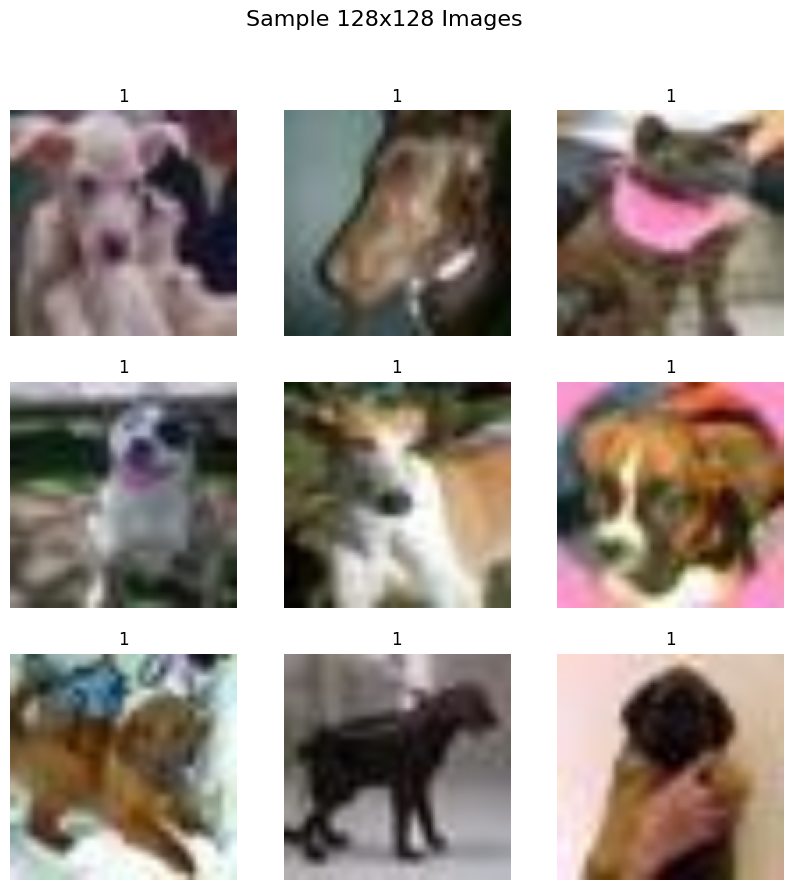

In [ ]:
# Take one batch from the augmented training dataset
import matplotlib.pyplot as plt

rescale = tf.keras.layers.Rescaling(1./255)

ds_highresimg = ds_highresimg.map(lambda x, y: (rescale(x), y))
ds_lowresimg = ds_lowresimg.map(lambda x, y: (rescale(x), y))

for images, labels in ds_highresimg.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9): # Display 9 images
        ax = plt.subplot(3, 3, i + 1)
        # Remove the batch dimension and convert tensor to numpy array
        plt.imshow(images[i])
        # Display label (assuming binary classification, adjust if needed)
        plt.title(int(labels[i]))
        plt.axis("off")
plt.suptitle('Sample 128x128 Images', fontsize = 16)
plt.show()

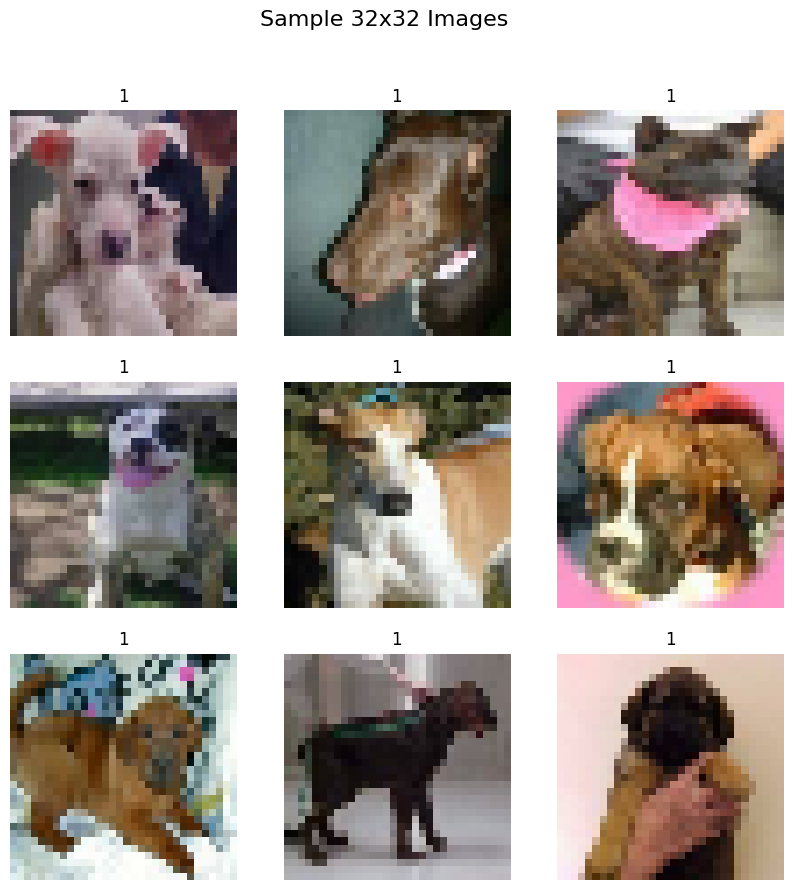

In [ ]:
# Take one batch from the augmented training dataset
for images, labels in ds_lowresimg.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9): # Display 9 images
        ax = plt.subplot(3, 3, i + 1)
        # Remove the batch dimension and convert tensor to numpy array
        plt.imshow(images[i].numpy())
        # Display label (assuming binary classification, adjust if needed)
        plt.title(int(labels[i]))
        plt.axis("off")
plt.suptitle('Sample 32x32 Images', fontsize = 16)
plt.show()